Author: Harshal Bhasgauri


In [ ]:
!pip install tensorflow==2.3.0
!pip install keras-rl2
#We both were working on google collab so this cell had to be run everytime the runtime would disconnect.

Importing Libraries

In [2]:
import numpy as np
import random
import gym
import numpy as np
import time
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

#Task: Goal is to perform Q-Learning & Deep-Q Learning on the agent in the CartPole-v1 gym environment.

##PART 1: Implement the Q-Learning Reinforcement Learning Algorithm on CartPole-v1 environment


> a. Display the performance of the random agent


> b. Compare the performance of the random agent to the RL-Agent 



I am creating a class named 'Q_learning' that will hold all functions that will be needed

In [3]:
class Q_learning:
    def __init__(self, env, alpha, gamma, epsilon, number_episodes, number_bins, lowerlimits, upperlimits):#__init__ function
      self.env = env#environment
      self.alpha = alpha #learning rate
      self.gamma = gamma #discoujnt factor
      self.epsilon = epsilon #exploration rate
      self.actions = env.action_space.n#actions
      self.number_episodes = number_episodes #max number of epsiodes
      self.number_bins = number_bins #This four-dimensional list will specify how many grid points will be used for
                                     # state discretization. i.e., it contains enough bins for each of the four 
                                     #entries in the observation space.(cart position, cart velocity, pole angle,
                                     # pole angular velocity)
                                     
      self.lowerlimits = lowerlimits #a list with 4 lower limits entries(of observation space) for discretization
      self.upperlimits = upperlimits #a list with 4 upper limits entries(of observation space) for discretization

      self.sumofrewardsperEpisode = [] #a list to store sum of reward in every learning episdoe
      
      
      #q-value function
      self.Qtable = np.random.uniform(low = 0, high = 1, size = (number_bins[0], number_bins[1],
                                                                 number_bins[2], number_bins[3], self.actions))
    
    def stateIndexdiscretizer(self, state):
      #This function, called "stateIndexdiscretizer," takes a four-dimensional state as input
      #and maps it to the corresponding indices of a Q-value matrix using a discretization grid
      #defined by the variables number_bins, lowerlimits, and upperlimits.
      cartposition = state[0]
      cartvelocity = state[1]
      poleangle = state[2]
      poleangularvelocity = state[3]

      position_bin = np.linspace(self.lowerlimits[0], self.upperlimits[0], self.number_bins[0])
      # The linspace function from the numpy library is used to create evenly spaced bins within these bounds.
      velocity_bin = np.linspace(self.lowerlimits[1], self.upperlimits[1], self.number_bins[1])
      angle_bin = np.linspace(self.lowerlimits[2], self.upperlimits[2], self.number_bins[2])
      angularvelocity_bin = np.linspace(self.lowerlimits[3], self.upperlimits[3], self.number_bins[3])

      position_index = np.maximum(np.digitize(state[0], position_bin)-1, 0)
      # the digitize function from numpy is used to find the index of the
      # bin that corresponds to each value in the input state. The resulting 
      # indices are then adjusted to ensure that they fall within the bounds of the
      # Q-value matrix using the maximum and minimum functions.
      velocity_index = np.maximum(np.digitize(state[1], velocity_bin)-1, 0)
      angle_index = np.maximum(np.digitize(state[2], angle_bin)-1, 0)
      angularvelocity_index = np.maximum(np.digitize(state[0], angularvelocity_bin)-1, 0)

      return tuple([position_index, velocity_index, angle_index, angularvelocity_index]) #fujnction returns a tuple containing the indices that correspond to the input state in the Q-value matrix. 
      
    
    def epsilon_greedy_approach(self, state, index):
      # this is the function for selecting action in current state that 
      #takes a state and an index as inputs and returns an action based
      # on an epsilon-greedy approach.. For first 350 episode I am allowing to select
      # completely random actions, in order to have enough exploration.
      if index < 350:
        return np.random.choice(self.actions)
      
      arandomnumber = np.random.random()# a random number

      #lowering the epsilon parameter after 2300 epsidoes(keeping in mind that the number of episodes is 3000)
      if index < 2300:
        self.epsilon = 0.999 * self.epsilon# i am decresing the exploration rate gradually over time to 
                                           #encourage the algorithm to become more exploitative as it learns.
      
      if arandomnumber < self.epsilon:
        return np.random.choice(self.actions)# returns a random action
      else:
        #we select greedy action
        A = self.Qtable[self.stateIndexdiscretizer(state)]
        #The method uses the Qtable attribute to look up the Q-values for the given state, which is first
        # discretized using the stateIndexdiscretizer method. It then returns a random action from the set
        # of actions that have the highest Q-value.
      return np.random.choice(np.where(A == np.max(A))[0])
      
    

    def train_and_simulate_episodes(self):
      #function that simulates multiple episodes of the CartPole-v1 environment using my Q-learning algorithm.
      #
      for episodeIndex in range(self.number_episodes):

        rewards_episode = []# a list for storing rewards per episdoe
        

        stateP = self.env.reset()
        stateP = list(stateP)

        print("episode # {}".format(episodeIndex))

        terminalState = False# flag variable

        while not terminalState:
          
          
          #return a discretized index of the state
          statePindex = self.stateIndexdiscretizer(stateP)#using function ('stateIndexdiscretizer') to store
                                                          #indices of current state in statePindex

          actionP = self.epsilon_greedy_approach(stateP, episodeIndex)
          #uses the epsilon_greedy_approach method to select an action (actionP) based on the current
          #state (stateP) and the current episode number (episodeIndex).
          (statePnext, reward, terminalState, _) = self.env.step(actionP)
          #performing step function and returnign the state, reward, and terminalState(boolean) denoting
          # if the state is a terminal state.

          rewards_episode.append(reward)

          statePnext = list(statePnext)
          statePnextIndex = self.stateIndexdiscretizer(statePnext)


          Qtablenext = np.max(self.Qtable[statePnextIndex])
          #Now i calculate the Q-value for the next state using the Qtable attribute
          #and update the Q-value for the current state and action using the Q-learning update rule.
          #for this I need to calculate 1.the temporal difference (TD) error, which is the
          #difference between the sum of the reward and the discounted maximum Q-value for the next 
          #state and 2.the current Q-value for the current state and action. 
          if not terminalState:
            
            error = reward + self.gamma * Qtablenext - self.Qtable[statePindex + (actionP,)]
            self.Qtable[statePindex + (actionP,)] = self.Qtable[statePindex + (actionP,)] +self.alpha*error
          else:
            error = reward - self.Qtable[statePindex + (actionP,)]
            self.Qtable[statePindex + (actionP,)] = self.Qtable[statePindex + (actionP,)] +self.alpha*error
          
          #setting current state to next state
          stateP = statePnext
        
        print("sum of rewards {}".format(np.sum(rewards_episode)))
        self.sumofrewardsperEpisode.append(np.sum(rewards_episode))
        
    
    #function for simulating the final learned optimal policy after training my Q-learning agent on the
    #environment using my Q-table.
    def simulatefinaloptimalpolicy(self):
        env1 = gym.make('CartPole-v1')#initializing a new environment 'env1'
        current_state = env1.reset()
        steps = 500

        rewards_obtained = []# for storing rewards obtaiend at each setp
        #this is the loop for choosing the action with the highest q valuefor the current state
        #using the Q-table. If multiple actions are having the same highest q
        # value, then it randomly chooses one of those actions.
        for t_index in range(steps):
          print(t_index)
          A = self.Qtable[self.stateIndexdiscretizer(current_state)]
          
          current_action_stateP = np.random.choice(np.where(A == np.max(A))[0])
          current_state, reward, done, info = env1.step(current_action_stateP)#performing step function
          rewards_obtained.append(reward)

          if (done):
            time.sleep(1)
            break
        return rewards_obtained, env1# returns rewards and environment instance 


    def plotgraph(self, cum_reward):
      self.cum_reward = cum_reward
      plt.plot(range(self.number_episodes), cum_reward)
      plt.xlabel('Episode')
      plt.ylabel('Cumulative Reward')
      plt.title('Cumulative Reward vs. Episode')
      plt.show()
      #function to plot cumulative reward vs number of episodes

    
    def simulaterandompolicyonrandomagent(self):
      #function for simulatign random policy on a random agent
      env2 = gym.make('CartPole-v1')# creating a new environment instance
      current_state = env2.reset()

      number_episodes = 100
      steps = 500
      randomsumofrewardsperEpisode = []
      averageofrewardsperEpisode = []

      for episode_index in range(number_episodes):
        rewards_each_episode = []#a list for storing reward in each and every episode

        state = env2.reset()
        print(episode_index)
        for t_index in range(steps):
          random_action = env2.action_space.sample()#In each step, a random action is selected 
          observation, reward, done, info = env2.step(random_action)
          rewards_each_episode.append(reward)
          if (done):
            break
        randomsumofrewardsperEpisode.append(np.sum(rewards_each_episode))
        # averageofrewardsperEpisode.append(rewards_each_episode / 500 for rewards_each_episode in reward)
      return randomsumofrewardsperEpisode, env2

      #this function is being created to first create a random action multiple times
      #and then will be used to compare this policy to final learned optimal poloicy



/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
env = gym.make('CartPole-v1')#initializing cartpole-v1 environment

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Defining parameters for state discretization

In [5]:
upperlimits = env.observation_space.high
lowerlimits = env.observation_space.low

In [6]:
cartvelocitymin = -3
cartvelocitymax = 3
poleangularvelocitymin = -10
poleangularvelocitymax = 10

In [7]:
upperlimits[1] = cartvelocitymax
upperlimits[3] = poleangularvelocitymax
lowerlimits[1] = cartvelocitymin
lowerlimits[3] = poleangularvelocitymin

In [8]:
#where nob is number of bins
position_nob = 30
velocity_nob = 30
angle_nob = 30
angularvelocity_nob = 30

In [9]:
number_of_bins = [position_nob, velocity_nob, angle_nob, angularvelocity_nob]

***Why did I use discretization?***
The state space of the cartpole environment is not discrete. this state is continous. So, I have used a discretization in order to approximate a continous state space by a finite discrete state spacce.

In [10]:
#define parameters
alpha = 0.1#learning rate
gamma = 1#discount factor
epsilon = 0.2#exploration rate
number_episodes = 3000

In [11]:
#creating object of my class

Qone = Q_learning(env, alpha, gamma, epsilon, number_episodes, number_of_bins, lowerlimits, upperlimits)

In [12]:
#Q learning algorithm

Qone.train_and_simulate_episodes()

Streaming output truncated to the last 5000 lines.
episode # 500
sum of rewards 70.0
episode # 501
sum of rewards 70.0
episode # 502
sum of rewards 69.0
episode # 503
sum of rewards 66.0
episode # 504
sum of rewards 55.0
episode # 505
sum of rewards 66.0
episode # 506
sum of rewards 79.0
episode # 507
sum of rewards 54.0
episode # 508
sum of rewards 80.0
episode # 509
sum of rewards 104.0
episode # 510
sum of rewards 58.0
episode # 511
sum of rewards 71.0
episode # 512
sum of rewards 94.0
episode # 513
sum of rewards 91.0
episode # 514
sum of rewards 54.0
episode # 515
sum of rewards 74.0
episode # 516
sum of rewards 98.0
episode # 517
sum of rewards 54.0
episode # 518
sum of rewards 38.0
episode # 519
sum of rewards 71.0
episode # 520
sum of rewards 48.0
episode # 521
sum of rewards 59.0
episode # 522
sum of rewards 91.0
episode # 523
sum of rewards 57.0
episode # 524
sum of rewards 70.0
episode # 525
sum of rewards 36.0
episode # 526
sum of rewards 63.0
episode # 527
sum of rewards 6

In [13]:
# simulating  the trained strategy
(optimal_rewards_obtained, env1) = Qone.simulatefinaloptimalpolicy()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54


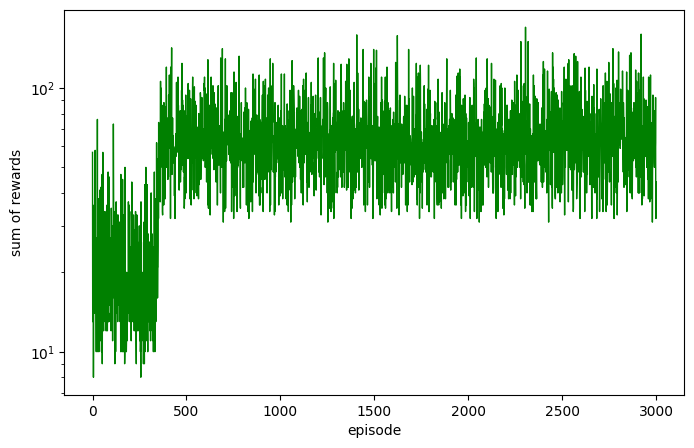

In [14]:
plt.figure(figsize=(8, 5))
# plot the figure and adjust the plot parameters
plt.plot(Qone.sumofrewardsperEpisode , color='green', linewidth=1)
plt.xlabel('episode')
plt.ylabel('sum of rewards')
plt.yscale('log')
plt.show()

Above is a graph that portrays performance of my q learning model. sum of rewards vs number of episodes. It can be seen that the sum of rewards is really low up till 350episodes as I allowed the simulation to run with random actions and full exploration rate in order to explore the action space fully. After 350 episodes the sum of rewards drastically changes and shows and exponential increase as epsilon greedy approach is used to choose highest reward action and update the q value function.After 2300 episodes the model is performing even well because I have started reducing exploration rate (epsilon) in order to exploit the model to full performance.

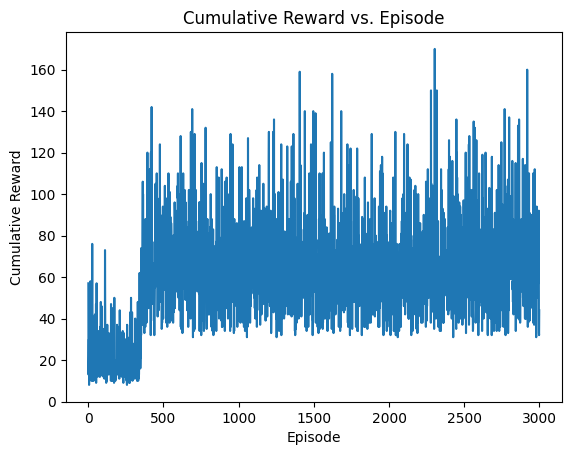

In [15]:
#plotting cumulative reward vs episode graph for Q learning agent
cumulative_reward = Qone.sumofrewardsperEpisode
Qone.plotgraph(cumulative_reward)
#comparison performed below

In [16]:
#simulating on random agent
(randomagentsumeofrewards, env2) = Qone.simulaterandompolicyonrandomagent()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


[  20.   35.   65.   79.  106.  124.  168.  181.  205.  226.  245.  266.
  284.  295.  328.  372.  407.  426.  436.  462.  480.  493.  510.  532.
  556.  597.  608.  651.  669.  681.  708.  733.  749.  766.  781.  800.
  818.  837.  857.  894.  957. 1001. 1013. 1035. 1077. 1101. 1121. 1141.
 1162. 1178. 1212. 1228. 1237. 1260. 1282. 1307. 1318. 1343. 1359. 1380.
 1393. 1407. 1427. 1447. 1460. 1471. 1483. 1508. 1558. 1593. 1610. 1624.
 1674. 1687. 1700. 1708. 1717. 1736. 1745. 1758. 1774. 1796. 1838. 1853.
 1865. 1883. 1905. 1924. 1946. 1962. 2024. 2052. 2089. 2099. 2131. 2142.
 2172. 2194. 2205. 2223.]


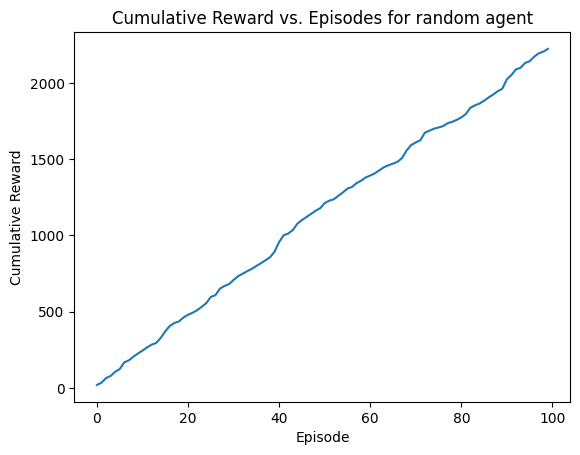

In [17]:
cumulative_reward_random = np.cumsum(randomagentsumeofrewards)
print(cumulative_reward_random)
random_episode_number = range(100)
plt.plot(random_episode_number, cumulative_reward_random)
plt.xlabel('Episode')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward vs. Episodes for random agent')
plt.show()

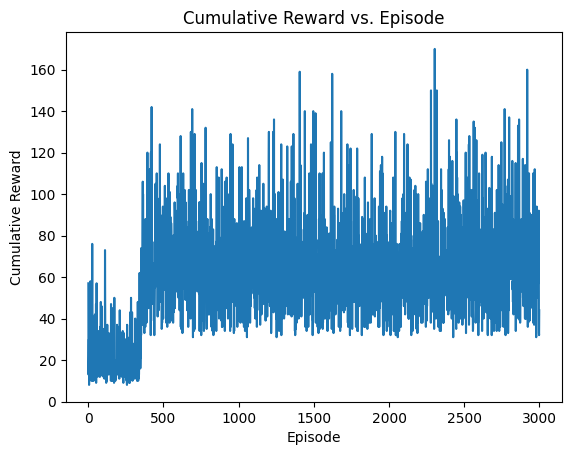

In [18]:
Qone.plotgraph(cumulative_reward)

figure 1 is a graph of Random Agent. Showing cumulative reward vs episodes. It is a linear graph where number of episodes range from 0 to 100. And cumulative reward ranges from 0 to 2343.

figure 2 is a graph of Q-learning Agent. Showing cumulative reward vs number of episodes. It is an exponentially rising graph where number of episodes range from 0 to 3000. And cumulative reward ranges from 0 to 165.

##PART 2: Implement the Deep-Q Network Algorithm using Keras RL library on CartPole-v1 environment


In [19]:
class Deep_Q_learning:
  def __init__(self, env, alpha, gamma, epsilon, num_episodes, num_bins, max_steps, min_exp_rate, exploration_decay_rate):
    self.env = env# environment
    self.alpha = alpha#learning factor
    self.gamma = gamma#discount factor
    self.epsilon = epsilon#exploration rate
    self.num_episodes = num_episodes
    self.num_bins = num_bins#number of bins
    self.max_steps = max_steps#maximum steps
    self.min_exp_rate = min_exp_rate#minimum exploration rate
    self.exploration_decay_rate = exploration_decay_rate#decay rate 

    
  
  def simulaterandomagent(self, state, action):
    #creating a function to simulate random action on a random agent
    self.state = state
    self.action = action
    episodes = 100#setting number of episodes as 100
    for episodes in range(1 + episodes+1):
      state = env.reset()
      done = False
      score = 0

      while not done:
        action = env.action_space.sample()# choosing a random action
        next_state, reward, done, info = env.step(action)#using step function to get next state, reward and bool(done)
        score += reward
      
      print("Episode # {} Score : {}".format(episodes, score))
  

  def build_model( self, states, actions):
    #creates a neural network model using the Keras API. The model architecture consists of three dense layers
    #followed by an output layer with a number of neurons equal to the number of actions.
    self.states = states
    self.actions = actions
    model = Sequential()
    model.add(Flatten(input_shape = (1, states)))
    model.add(Dense(24, activation = 'relu'))
    model.add(Dense(24, activation = 'relu'))
    model.add(Dense(actions, activation = 'relu'))
    return model
  
  def build_agent( self, model, actions):
    #creating a function for building a DQNAgent. my funtion takes in a keras neural
    #network model, the number of possible actions, and returns a DQNAgent object.
    self.model = model
    self.actions = actions
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit = 50000, window_length = 1)
    DQN = DQNAgent(model = model, memory = memory, policy = policy, nb_actions = actions,
                   nb_steps_warmup = 10, target_model_update = 1e-2)
    return DQN
  

  def dqn_compile_and_fit(self, built_agent):
    #This function first compiles the agent using the Adam optimizer with a learning rate and the mean absolute
    # error as the metric. It then fits the agent to the environment for 50000 steps and returns the history
    # of the training process.
    self.built_agent = built_agent
    built_agent.compile(tf.keras.optimizers.legacy.Adam(learning_rate = 1e-3), metrics = ['mae'])
    history = built_agent.fit(env, nb_steps = 50000, visualize = False, verbose = 1)
    return history
  

  def dqn_test(self, built_agent, num_test_episodes):
    # tests the performance of the trained DQN agent on the environment by running a specified number of
    # episodes and computing the average episode reward. resulting score object contains information
    # about the episode rewards, which are averaged using np.mean and printed to the console.
    self.built_agent = built_agent
    self.num_test_episodes = num_test_episodes
    score = built_agent.test(env, nb_episodes = num_test_episodes, visualize = False)
    print(np.mean(score.history['episode_reward']))
  

  def plotgraphs(self, avg_rwrd, cum_rwrd):
    #The first plot shows the average reward per move for each episode
    plt.plot(avg_rwrd)
    plt.title('Average Reward per Move')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.show()

    # The second plot shows the cumulative reward obtained over time (in steps) for each episode
    plt.plot(cum_rwrd)
    plt.title('Cumulative Reward in steps vs. Number of Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.show()



In [20]:
#setting parameters
D_alpha = 0.1
D_gamma = 0.99
D_epsilon = 1
D_num_episodes = 1000
D_num_bins = 100
D_max_steps= 200
D_min_exploration_rate = 0.01
D_exploration_decay_rate = 0.001

In [22]:
#creating a object of class 'Deep_Q_learning'
Qtwo = Deep_Q_learning( env, D_alpha, D_gamma, D_epsilon, D_num_episodes, D_num_bins, D_max_steps, D_min_exploration_rate, D_exploration_decay_rate)

In [23]:
#initialize the Q-table
D_states = env.observation_space.shape[0]
D_actions = env.action_space.n

In [24]:
#simulating random agent
Qtwo.simulaterandomagent(D_states, D_actions)

Episode # 0 Score : 15.0
Episode # 1 Score : 15.0
Episode # 2 Score : 13.0
Episode # 3 Score : 17.0
Episode # 4 Score : 46.0
Episode # 5 Score : 19.0
Episode # 6 Score : 15.0
Episode # 7 Score : 21.0
Episode # 8 Score : 17.0
Episode # 9 Score : 25.0
Episode # 10 Score : 13.0
Episode # 11 Score : 17.0
Episode # 12 Score : 42.0
Episode # 13 Score : 21.0
Episode # 14 Score : 14.0
Episode # 15 Score : 23.0
Episode # 16 Score : 13.0
Episode # 17 Score : 30.0
Episode # 18 Score : 12.0
Episode # 19 Score : 16.0
Episode # 20 Score : 17.0
Episode # 21 Score : 24.0
Episode # 22 Score : 31.0
Episode # 23 Score : 10.0
Episode # 24 Score : 26.0
Episode # 25 Score : 15.0
Episode # 26 Score : 45.0
Episode # 27 Score : 23.0
Episode # 28 Score : 15.0
Episode # 29 Score : 16.0
Episode # 30 Score : 13.0
Episode # 31 Score : 13.0
Episode # 32 Score : 17.0
Episode # 33 Score : 14.0
Episode # 34 Score : 18.0
Episode # 35 Score : 29.0
Episode # 36 Score : 23.0
Episode # 37 Score : 13.0
Episode # 38 Score : 2

In [25]:
#storing our model in variable
DQN_model = Qtwo.build_model(D_states, D_actions)

In [26]:
DQN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 24)                120       
                                                                 
 dense_1 (Dense)             (None, 24)                600       
                                                                 
 dense_2 (Dense)             (None, 2)                 50        
                                                                 
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________


In [27]:
#building our agent
DQN_agent = Qtwo.build_agent( DQN_model, D_actions)

In [28]:
history = Qtwo.dqn_compile_and_fit(DQN_agent)

Training for 50000 steps ...
Interval 1 (0 steps performed)
    1/10000 [..............................] - ETA: 15:35 - reward: 1.0000

/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.9/dist-packages/rl/memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')
/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 10 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)


   31/10000 [..............................] - ETA: 4:38 - reward: 1.0000

/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 11 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 12 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 13 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 14 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 15 + 1) instead
  batch_idxs

10000/10000 [==============================] - 104s 10ms/step - reward: 1.0000
101 episodes - episode_reward: 98.069 [10.000, 413.000] - loss: 2.325 - mae: 19.070 - mean_q: 38.750

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 99s 10ms/step - reward: 1.0000
48 episodes - episode_reward: 209.396 [152.000, 340.000] - loss: 2.908 - mae: 40.437 - mean_q: 81.894

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 100s 10ms/step - reward: 1.0000
51 episodes - episode_reward: 194.333 [116.000, 384.000] - loss: 1.367 - mae: 38.291 - mean_q: 77.119

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 101s 10ms/step - reward: 1.0000
47 episodes - episode_reward: 213.128 [142.000, 325.000] - loss: 0.889 - mae: 33.701 - mean_q: 67.733

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 107s 11ms/step - reward: 1.0000
done, took 510.793 seconds


In [29]:
#performing test
Qtwo.dqn_test(DQN_agent, 100)

Testing for 100 episodes ...
Episode 1: reward: 361.000, steps: 361
Episode 2: reward: 359.000, steps: 359
Episode 3: reward: 363.000, steps: 363
Episode 4: reward: 361.000, steps: 361
Episode 5: reward: 349.000, steps: 349
Episode 6: reward: 332.000, steps: 332
Episode 7: reward: 351.000, steps: 351
Episode 8: reward: 335.000, steps: 335
Episode 9: reward: 339.000, steps: 339
Episode 10: reward: 355.000, steps: 355
Episode 11: reward: 359.000, steps: 359
Episode 12: reward: 355.000, steps: 355
Episode 13: reward: 334.000, steps: 334
Episode 14: reward: 339.000, steps: 339
Episode 15: reward: 345.000, steps: 345
Episode 16: reward: 322.000, steps: 322
Episode 17: reward: 333.000, steps: 333
Episode 18: reward: 333.000, steps: 333
Episode 19: reward: 363.000, steps: 363
Episode 20: reward: 371.000, steps: 371
Episode 21: reward: 357.000, steps: 357
Episode 22: reward: 339.000, steps: 339
Episode 23: reward: 321.000, steps: 321
Episode 24: reward: 353.000, steps: 353
Episode 25: reward: 

In [30]:
cumulative_reward = np.cumsum(history.history['episode_reward'])
average_reward = cumulative_reward / np.arange(1, len(cumulative_reward) + 1)

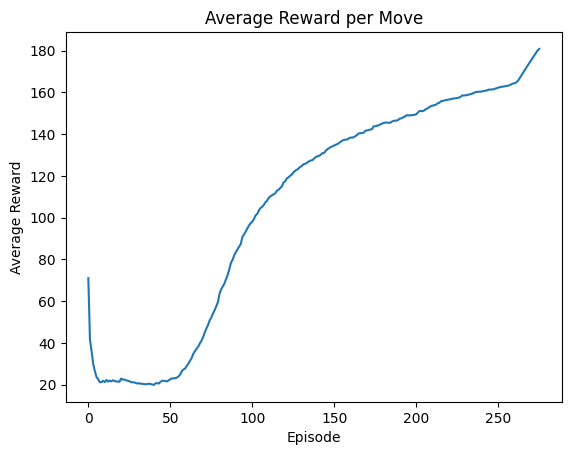

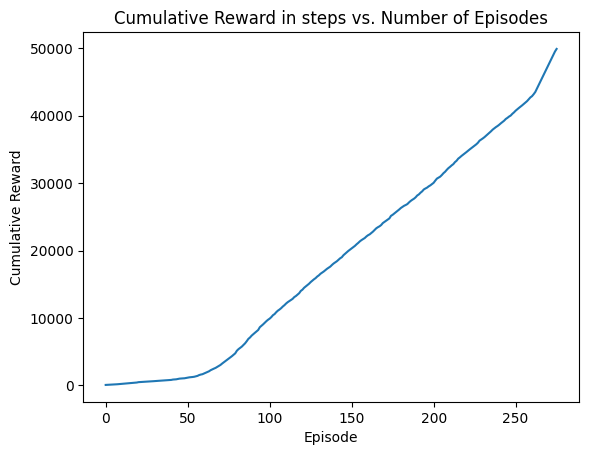

In [31]:
#plotting graphs
Qtwo.plotgraphs(average_reward, cumulative_reward)

*Extremely sorry for labelling x-lable as Episodes. It is not episodes. It is cumulative reward.*

Figure 1 is average reward per move of our DQN model.Average reward per move is a exponential graph as it drops from 40 on 0th episode and reaches to 180 all the way from 0. Which shows that the model is performing really well.

Figure 2 is number of steps vs cumulative reward. It shows a linear graph which is a great sign as this means that my model is performing really well.